# Sorting and violations

In this notebook:
<ol>
    <li> Sorting and filtering (complete, incomplete trajectories & pedestrians)
    <li> Visualizing trajectories (as sets of Points) with matplotlib.pyplot
    <ol>
        <li>preprocessing: coloring trajectories based on start/end
        <li>as subplots
        <li>as individual plots
    </ol>
    <li> Violations
    <li> Coloring trajectories as LineStrings
</ol>

In [2]:
import pandas as pd
import geopandas as gpd
from add_geometry_points import add_geometry, locate
import math
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Create geodataframe and locate trajectories
zones = gpd.read_file("C:/Users/anape/Downloads/outsight/resources/QGIS/lanes_and_int.geojson")
gdf = add_geometry("C:/Users/anape/Downloads/outsight/resources/0109-traj.csv")
gdf = locate(gdf, "C:/Users/anape/Downloads/outsight/resources/QGIS/lanes_and_int.geojson")

In [5]:
# Drop unnecessary columns
gdf.drop('speed_kmh',axis=1, inplace=True)
gdf.drop('zones',axis=1, inplace=True)
gdf.drop('z',axis=1, inplace=True)
gdf.drop('volume_m3',axis=1, inplace=True)
gdf.drop('index_right',axis=1, inplace=True)

## Sorting and filtering
The following sorting is based on heuristics and is likely to produce imperfect results. The goal is to make a cheap-and-easy sorting that is usable rather than a perfect sorting.

In [6]:
results = [] # to keep track of trajectory loc lists
results_ids = []
pedestrians = []
incomplete = []

for i,group in gdf.groupby('object_id'):
    locations = group['id'].tolist()
    m = (group['to_inter'].unique()).tolist()
    nan_count = np.sum(np.isnan(locations))
    total_count = len(locations)
    
    # If 75% or more time NaN location (pedestrian zones are NaN)
    if nan_count > total_count / 1.5:
        pedestrians.append(i)

    # If the object visits lanes that enter and leave the intersection
    elif 0 in m and 1 in m:
        k = (group['id'].unique()).tolist()
        
        # drop NaN values
        k = list(filter(lambda value: not math.isnan(value), k))
        if 0 in k and len(k) >= 3 and k[0] != 0 and k[-1] != 0:
            j = k.index(0)
            results.append([k[j-1],k[j+1],i])
            results_ids.append(i)

    # If not a complete trajectory
    else:
        incomplete.append(i)


# Split complete, pedestrians and incomplete
perfect_traj = gdf[gdf['object_id'].isin(results_ids)].set_index('object_id')
incomplete_traj = gdf[gdf['object_id'].isin(incomplete)].set_index('object_id')
pedestrian_traj = gdf[gdf['object_id'].isin(pedestrians)].set_index('object_id')

## Visualizing trajectories
For the lack of a better test, I still like to assess results visually.
To make the plot clearer, trajectories are color-coded (0 is the start, 1 is the end), which requires a bit of pre-processing (normalization f-n below).

In [12]:
# Normalize frame number series from 1 to 0 (for plotting purposes)
def inplace_normalize_0_to_1(group):
    min_val = group['frame_number'].min()
    max_val = group['frame_number'].max()

    # To avoid errors if running the function on an already normalized df
    if min_val != 0 or max_val != 1:
        group['frame_number'] = (group['frame_number'] - min_val) / (max_val - min_val)
    
    return group


In [212]:
# Apply in-place normalization for each group
perfect_traj = perfect_traj.groupby('object_id').apply(inplace_normalize_0_to_1)
incomplete_traj = incomplete_traj.groupby('object_id').apply(inplace_normalize_0_to_1)
pedestrian_traj = pedestrian_traj.groupby('object_id').apply(inplace_normalize_0_to_1)

In [215]:
# Get counts
s1 = perfect_traj.groupby('object_id').ngroups
s2 = incomplete_traj.groupby('object_id').ngroups
s3 = pedestrian_traj.groupby('object_id').ngroups

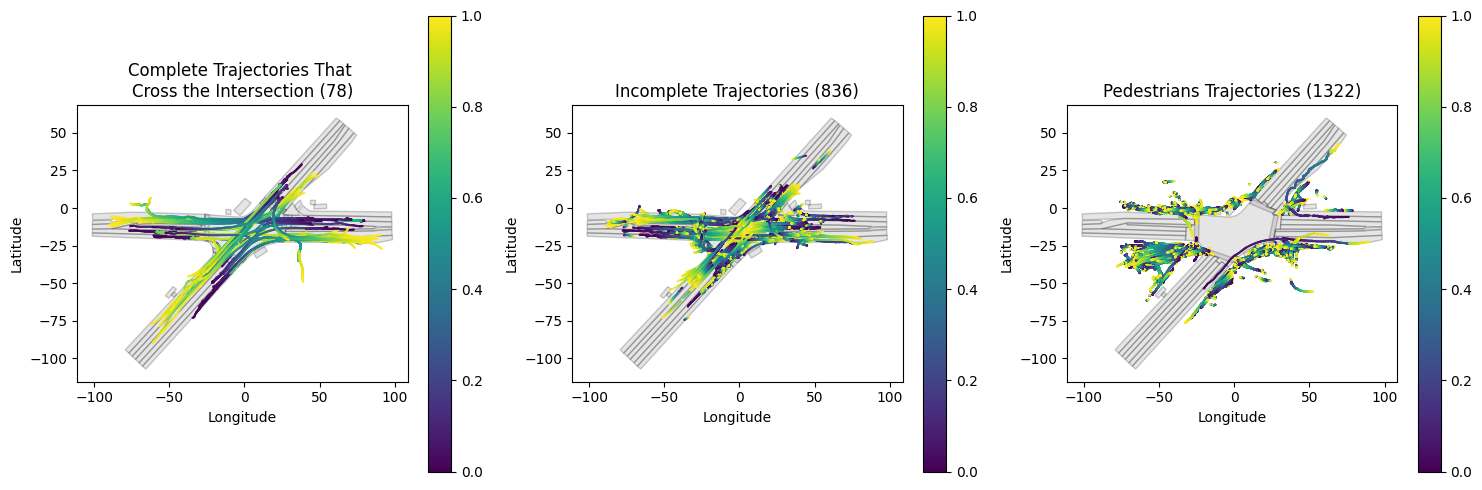

In [224]:
# All three plots at the same time.

s = [s1, s2, s3]
titles = [f'Complete Trajectories That \nCross the Intersection ({s1})', f'Incomplete Trajectories ({s2})', f'Pedestrians Trajectories ({s3})']
trajs = [perfect_traj, incomplete_traj, pedestrian_traj]



fix, axes = plt.subplots(1, 3, figsize=(15, 5))  # 1x3 grid of subplots

for i in [0, 1, 2]:
    ax = axes[i] 
    zones.plot(color='gray', alpha=0.2, edgecolor='black', ax=ax)
    trajs[i].plot(marker='.', markersize=1, column='frame_number', cmap='viridis', legend=True, ax=ax)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Complete Trajectories That \nCross the Intersection (78)')

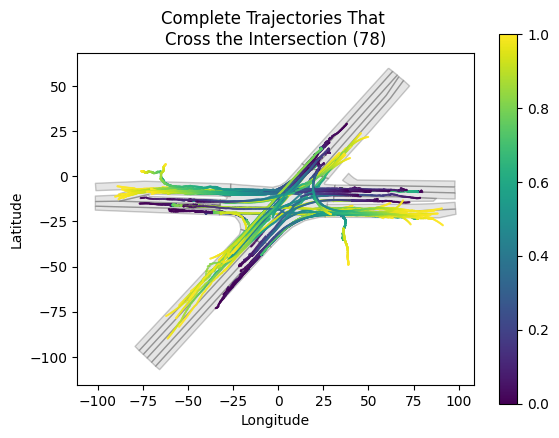

In [226]:
# Plot complete trajectories
ax = zones.plot(color='gray', alpha=0.2, edgecolor='black')
perfect_traj.plot(marker='.', markersize=1,column='frame_number', cmap='viridis', legend=True, ax = ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Complete Trajectories That \nCross the Intersection ({s1})')

Text(0.5, 1.0, 'Incomplete Trajectories (836)')

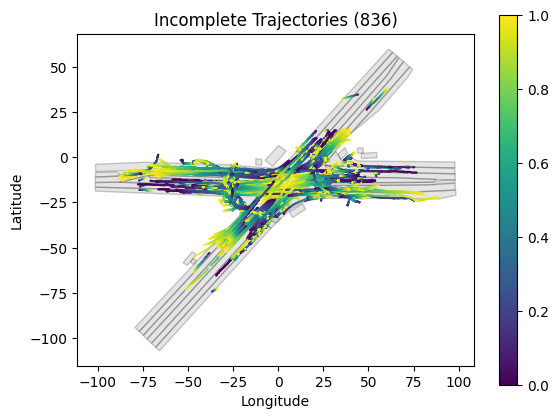

In [213]:
# Plot incomplete trajectories
ax = zones.plot(color='gray', alpha=0.2, edgecolor='black')
incomplete_traj.plot(marker='.', markersize=1,column='frame_number', cmap='viridis', legend=True, ax = ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Incomplete Trajectories ({s2})')

Text(0.5, 1.0, 'Pedestrians Trajectories (1321)')

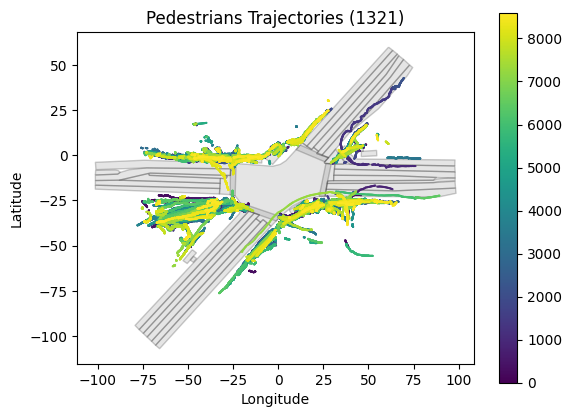

In [187]:
# Plot pedestrians
ax = zones.plot(color='gray', alpha=0.2, edgecolor='black')
pedestrian_traj.plot(marker='.', markersize=1,column='frame_number', cmap='viridis', legend=True, ax = ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Pedestrians Trajectories ({s3})')

## Violations

Checking for violations and plotting trajectories. Uses the filtering from above (it only makes sense to check if the complete trajectories are illegal).

In [7]:
# All legal directions for lanes going toward the interection
# Assumption: an object can turn left/right/straight in any lane they like
# Manually created, but can be done using the lanes' properties too.

legal = {1:[15,16,17,21,22],2:[15,16,17],3:[10,11],6:[5],7:[21,22],8:[21,22,15,16,17],9:[15,16,17],12:[10,11,5,4],13:[5,4],14:[21,22],18:[15,16,17,10,11],19:[10,11],20:[5,4]}

In [24]:
violations = []
for i in results:
    if i[1] not in legal[i[0]]:
        violations.append(i)

violators = [i[2] for i in violations]
violations

[[14.0, 4.0, 11295406], [13.0, 10.0, 11295464], [14.0, 5.0, 11297739]]

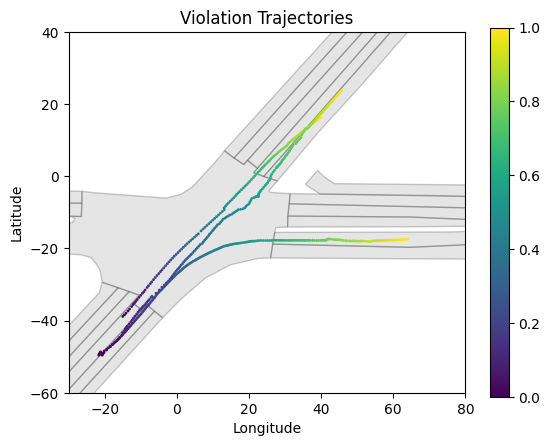

In [23]:
ax = zones.plot(color='gray', alpha=0.2, edgecolor='black')
violations_gdf = gdf[gdf['object_id'].isin(violators)]
violations_gdf = violations_gdf.groupby('object_id').apply(inplace_normalize_0_to_1)
violations_gdf.plot(marker='.', markersize=4, column='frame_number', cmap='viridis', legend=True, ax=ax)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title(f'Violation Trajectories')
plt.xlim([-30,80])
plt.ylim([-60,40])
plt.show()

## Coloring trajectories as LineStrings
Finally, here is another attempt at coloring trajectories (to easily distinguish start and end), this time working with trajectories as LineStrings. As of now, it takes forever to run (3 min on a good day).

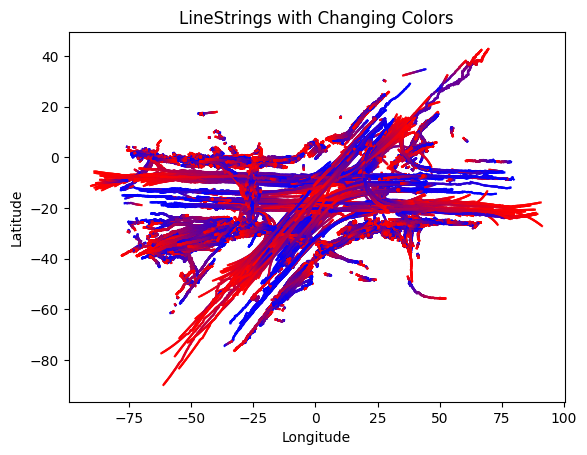

CPU times: total: 1min 59s
Wall time: 5min 21s


In [229]:
%%time

import add_geometry_lines as agl
from matplotlib.colors import LinearSegmentedColormap


gdf = agl.add_geometry("C:/Users/anape/Downloads/outsight/resources/0109-traj.csv")

#  custom colormap
cmap = LinearSegmentedColormap.from_list('color_map', ['blue', 'red'])

fig, ax = plt.subplots()

# Iterate through GeoDataFrame rows and plot LineStrings with changing colors
for index, row in gdf.iterrows():
    coords = row['geometry'].coords
    num_segments = len(coords) - 1
    for i in range(num_segments):
        segment = [coords[i], coords[i + 1]]
        color = cmap(i / num_segments)
        ax.plot(*zip(*segment), color=color)

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('LineStrings with Changing Colors')

plt.show()
